In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vcg16/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/flicker-8k-image-dataset-captionstxt/captions.txt
/kaggle/input/flicker-8k-image-dataset-captionstxt/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flicker-8k-image-dataset-captionstxt/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flicker-8k-image-dataset-captionstxt/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flicker-8k-image-dataset-captionstxt/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flicker-8k-image-dataset-captionstxt/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flicker-8k-image-dataset-captionstxt/Images/2752809449_632cd991b3.jpg
/kaggle/input/flicker-8k-image-dataset-captionstxt/Images/3097776588_312932e438.jpg
/kaggle/input/flicker-8k-image-dataset-captionstxt/Images/1206506157_c7956accd5.jpg
/kaggle/input/flicker-8k-image-dataset-captionstxt/Images/1319634306_816f21677f.jpg
/kaggle/input/flicker-8k-image-dataset-captionstxt/Images/2465218087_fca77998c6.jpg
/kaggle/inp

In [12]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [13]:
BASE_DIR ='/kaggle/input/flicker-8k-image-dataset-captionstxt'
WORKING_DIR = '/kaggle/working'

In [14]:
# load vgg16 model
weights_path = '/kaggle/input/vcg16/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
model = VGG16(weights=weights_path)
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
features={}
directory=os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    
    # convert image pixels to numpy array
    image = img_to_array(image)
    
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # preprocess image for vgg
    image = preprocess_input(image)
    
    # extract features
    feature = model.predict(image, verbose=0)
    
    # get image ID
    image_id = img_name.split('.')[0]
    
    # store feature
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [19]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

#### captions file loading


In [21]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [22]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [23]:
len(mapping)

8091

### preprocessing


In [37]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [38]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [39]:
# preprocess the text
clean(mapping)

In [40]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq',
 'startseq startseq girl going into wooden building endseq endseq',
 'startseq startseq little girl climbing into wooden playhouse endseq endseq',
 'startseq startseq little girl climbing the stairs to her playhouse endseq endseq',
 'startseq startseq little girl in pink dress going into wooden cabin endseq endseq']

In [41]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [42]:
len(all_captions)


40455

In [43]:
all_captions[:10]


['startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq',
 'startseq startseq girl going into wooden building endseq endseq',
 'startseq startseq little girl climbing into wooden playhouse endseq endseq',
 'startseq startseq little girl climbing the stairs to her playhouse endseq endseq',
 'startseq startseq little girl in pink dress going into wooden cabin endseq endseq',
 'startseq startseq black dog and spotted dog are fighting endseq endseq',
 'startseq startseq black dog and tri-colored dog playing with each other on the road endseq endseq',
 'startseq startseq black dog and white dog with brown spots are staring at each other in the street endseq endseq',
 'startseq startseq two dogs of different breeds looking at each other on the road endseq endseq',
 'startseq startseq two dogs on pavement moving toward each other endseq endseq']

In [44]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [45]:
vocab_size

8485

In [46]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

37

### train and test splitting

In [47]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [48]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

### Model Creation:

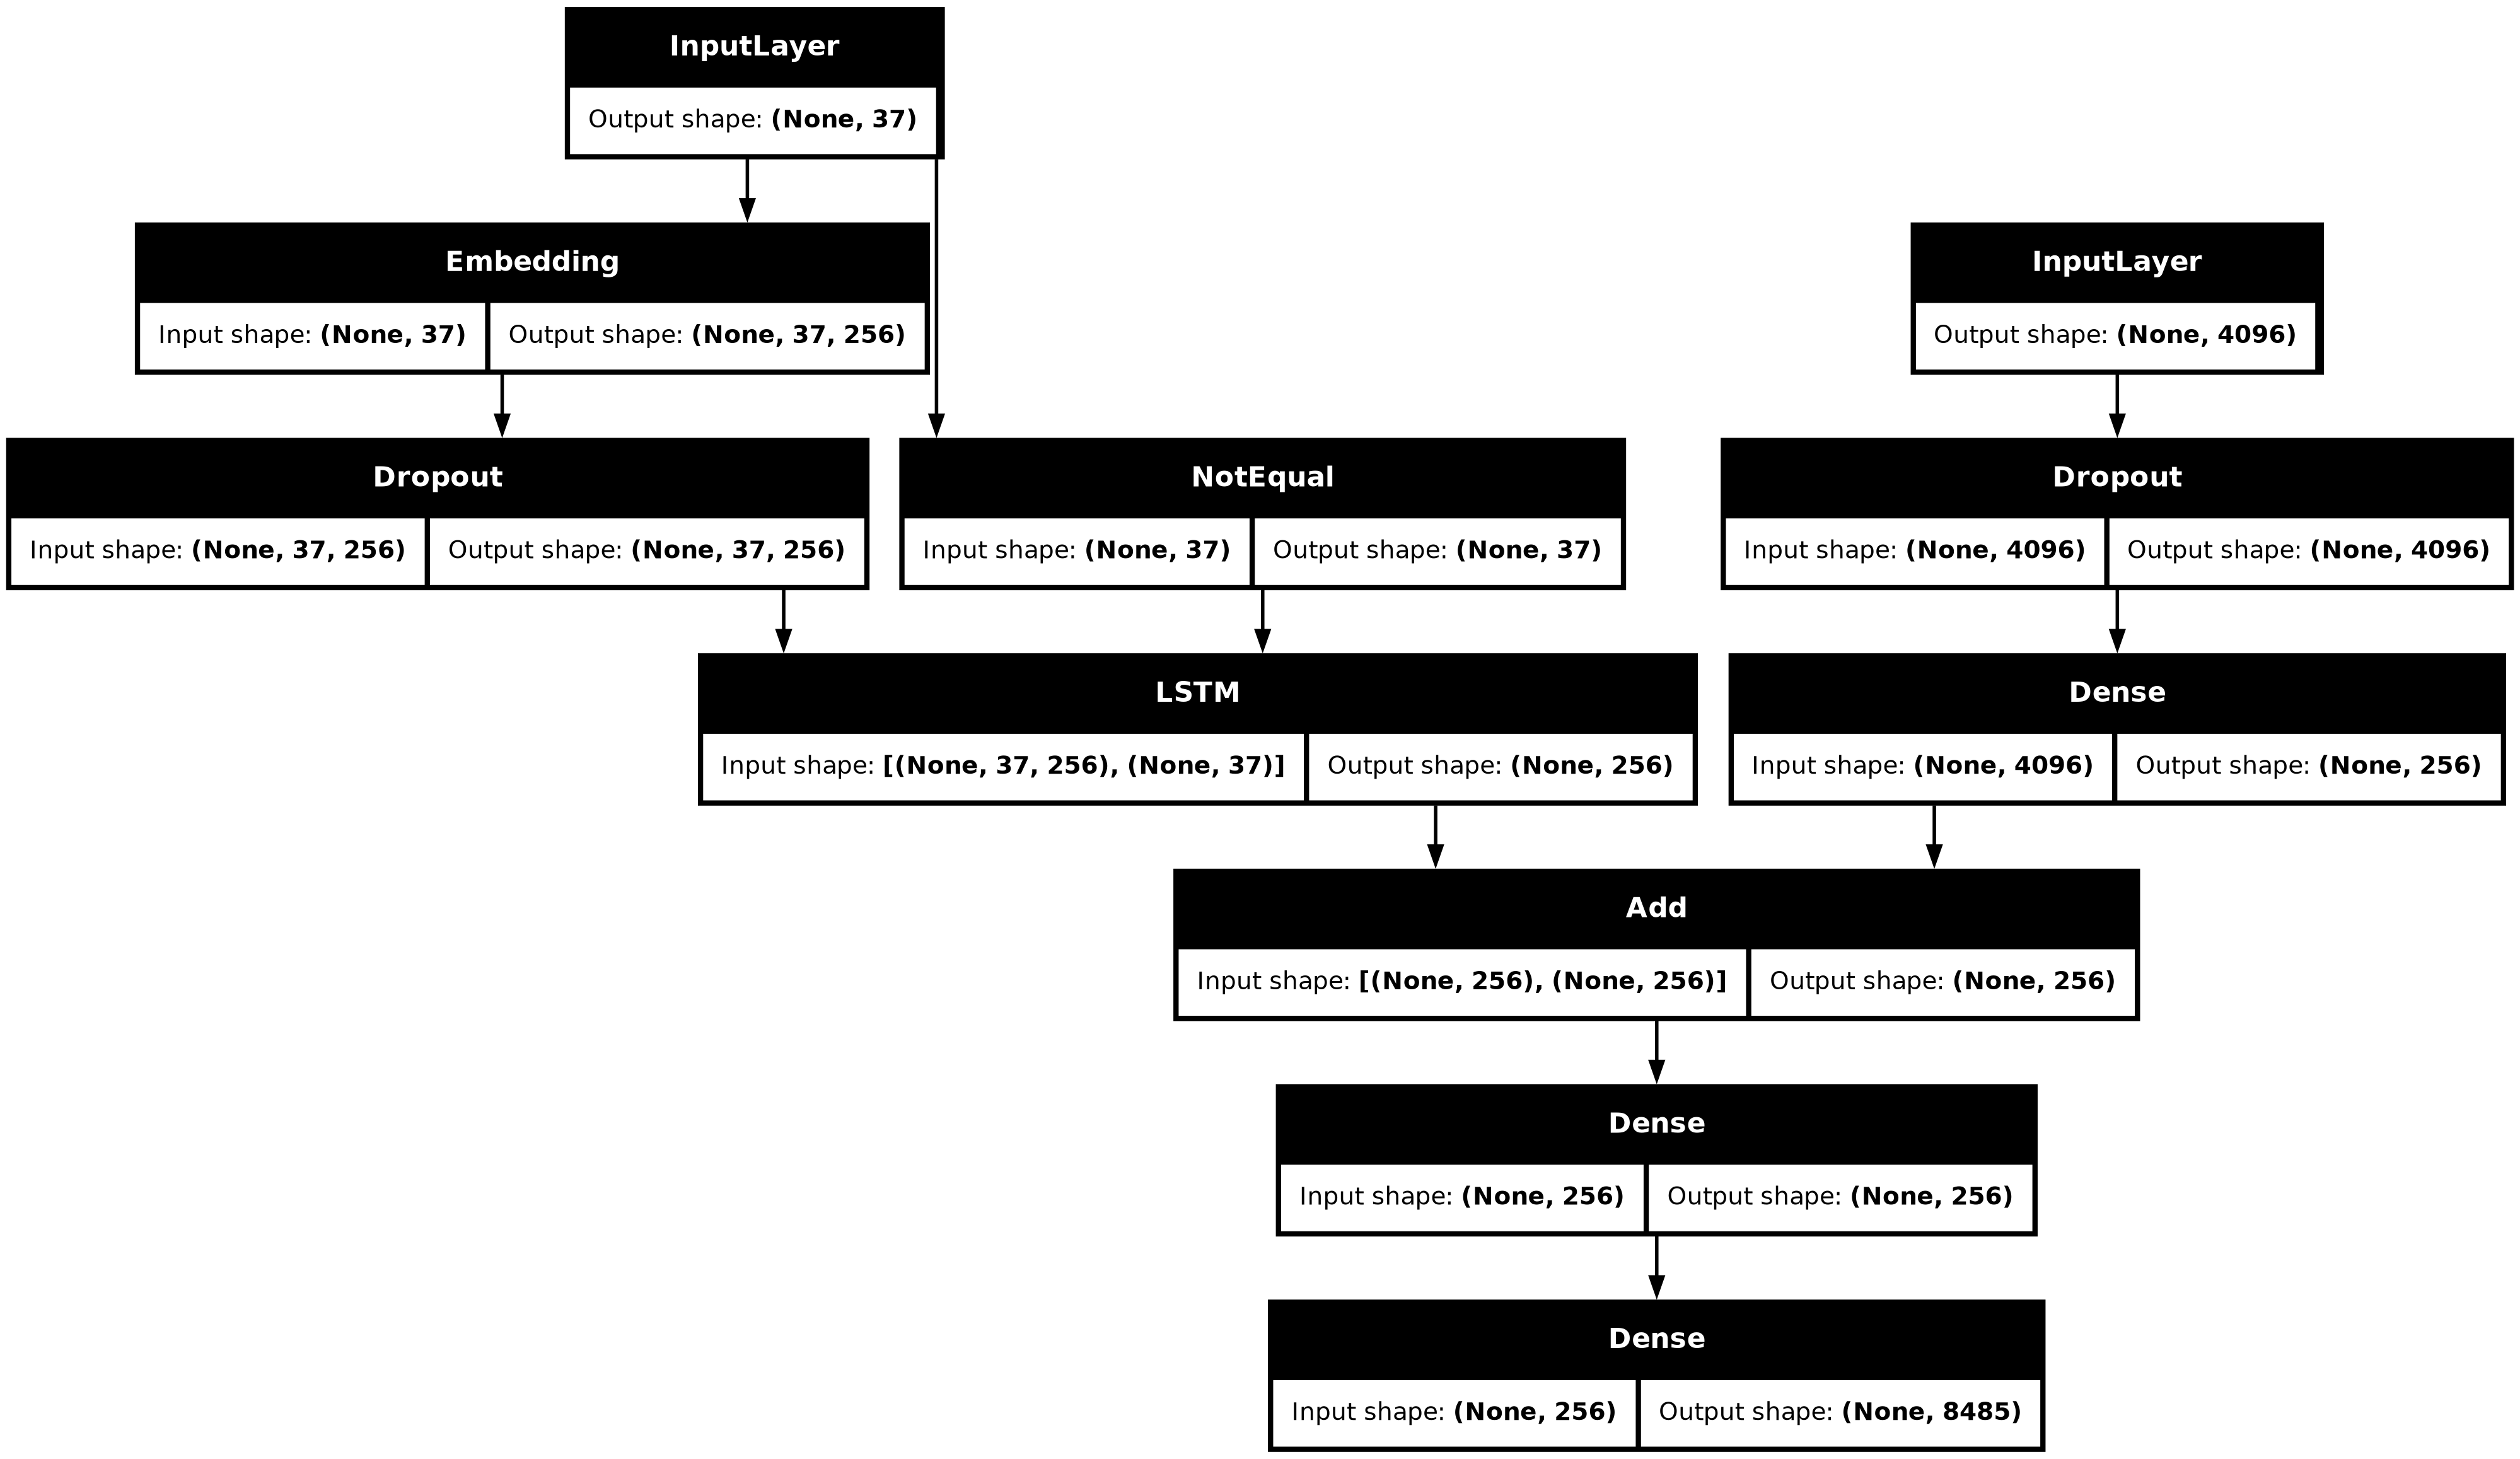

In [49]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

### train the model

In [50]:
# train the model
epochs = 35
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  1/227 ━━━━━━━━━━━━━━━━━━━━ 27:21 7s/step - loss: 9.0800

W0000 00:00:1722977801.519357     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977801.587897     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977801.671349     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  2/227 ━━━━━━━━━━━━━━━━━━━━ 16:51 4s/step - loss: 8.9263

W0000 00:00:1722977806.020969     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977806.087968     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977806.167005     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/227 ━━━━━━━━━━━━━━━━━━━━ 16:44 4s/step - loss: 8.7116

W0000 00:00:1722977810.510944     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977810.572456     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977810.640470     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/227 ━━━━━━━━━━━━━━━━━━━━ 16:48 5s/step - loss: 8.4985

W0000 00:00:1722977815.097182     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977815.163934     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977815.242500     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/227 ━━━━━━━━━━━━━━━━━━━━ 16:44 5s/step - loss: 8.3105

W0000 00:00:1722977819.616692     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977819.683439     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977819.763208     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/227 ━━━━━━━━━━━━━━━━━━━━ 14:02 4s/step - loss: 7.9837

W0000 00:00:1722977824.491600     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977824.559466     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977824.640147     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/227 ━━━━━━━━━━━━━━━━━━━━ 14:18 4s/step - loss: 7.8477

W0000 00:00:1722977828.961251     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977829.028452     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977829.101042     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/227 ━━━━━━━━━━━━━━━━━━━━ 14:32 4s/step - loss: 7.7293

W0000 00:00:1722977833.557656     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977833.625980     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977833.706801     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 10/227 ━━━━━━━━━━━━━━━━━━━━ 14:43 4s/step - loss: 7.6254

W0000 00:00:1722977838.182930     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977838.251816     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977838.330471     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/227 ━━━━━━━━━━━━━━━━━━━━ 14:50 4s/step - loss: 7.5317

W0000 00:00:1722977842.744423     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977842.810440     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977842.888567     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/227 ━━━━━━━━━━━━━━━━━━━━ 14:55 4s/step - loss: 7.4472

W0000 00:00:1722977847.352642     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977847.420383     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977847.500422     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 13/227 ━━━━━━━━━━━━━━━━━━━━ 15:00 4s/step - loss: 7.3707

W0000 00:00:1722977851.990093     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977852.058559     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977852.139174     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/227 ━━━━━━━━━━━━━━━━━━━━ 15:02 4s/step - loss: 7.3010

W0000 00:00:1722977856.581229     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977856.648796     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977856.728371     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/227 ━━━━━━━━━━━━━━━━━━━━ 15:02 4s/step - loss: 7.2365

W0000 00:00:1722977861.125653     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977861.186620     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977861.254893     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/227 ━━━━━━━━━━━━━━━━━━━━ 15:03 4s/step - loss: 7.1778

W0000 00:00:1722977865.788581     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977865.854634     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977865.934054     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 17/227 ━━━━━━━━━━━━━━━━━━━━ 15:04 4s/step - loss: 7.1234

W0000 00:00:1722977870.431875     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977870.498274     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977870.576605     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/227 ━━━━━━━━━━━━━━━━━━━━ 15:06 4s/step - loss: 7.0718

W0000 00:00:1722977875.246140     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977875.311985     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977875.389392     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/227 ━━━━━━━━━━━━━━━━━━━━ 15:05 4s/step - loss: 7.0238

W0000 00:00:1722977879.870945     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977879.938230     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977880.017734     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/227 ━━━━━━━━━━━━━━━━━━━━ 15:03 4s/step - loss: 6.9790

W0000 00:00:1722977884.501471     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977884.562620     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977884.633776     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/227 ━━━━━━━━━━━━━━━━━━━━ 15:02 4s/step - loss: 6.9368

W0000 00:00:1722977889.149979     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977889.216493     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977889.294281     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/227 ━━━━━━━━━━━━━━━━━━━━ 14:58 4s/step - loss: 6.8967

W0000 00:00:1722977893.606268     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977893.666610     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977893.736906     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 23/227 ━━━━━━━━━━━━━━━━━━━━ 14:56 4s/step - loss: 6.8587

W0000 00:00:1722977898.245795     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977898.313068     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977898.390409     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/227 ━━━━━━━━━━━━━━━━━━━━ 14:55 4s/step - loss: 6.8228

W0000 00:00:1722977902.995086     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977903.063574     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977903.146769     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 25/227 ━━━━━━━━━━━━━━━━━━━━ 14:53 4s/step - loss: 6.7886

W0000 00:00:1722977907.663752     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977907.729695     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977907.807475     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/227 ━━━━━━━━━━━━━━━━━━━━ 14:50 4s/step - loss: 6.7563

W0000 00:00:1722977912.302119     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977912.368640     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977912.444983     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 27/227 ━━━━━━━━━━━━━━━━━━━━ 14:47 4s/step - loss: 6.7256

W0000 00:00:1722977916.903575     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977916.971132     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977917.050848     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 28/227 ━━━━━━━━━━━━━━━━━━━━ 14:44 4s/step - loss: 6.6962

W0000 00:00:1722977921.511209     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977921.577096     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977921.654826     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/227 ━━━━━━━━━━━━━━━━━━━━ 13:36 4s/step - loss: 6.6151

W0000 00:00:1722977926.489428     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977926.556732     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977926.638041     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 32/227 ━━━━━━━━━━━━━━━━━━━━ 13:35 4s/step - loss: 6.5901

W0000 00:00:1722977931.102992     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977931.168949     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977931.247147     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 33/227 ━━━━━━━━━━━━━━━━━━━━ 13:33 4s/step - loss: 6.5658

W0000 00:00:1722977935.750582     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977935.811631     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977935.882866     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/227 ━━━━━━━━━━━━━━━━━━━━ 13:04 4s/step - loss: 6.5197

W0000 00:00:1722977940.529561     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977940.597451     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977940.679152     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/227 ━━━━━━━━━━━━━━━━━━━━ 13:04 4s/step - loss: 6.4977

W0000 00:00:1722977945.238933     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977945.242634     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977945.307900     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977945.386370     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 37/227 ━━━━━━━━━━━━━━━━━━━━ 13:03 4s/step - loss: 6.4763

W0000 00:00:1722977949.923014     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977949.989149     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977950.074509     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/227 ━━━━━━━━━━━━━━━━━━━━ 13:02 4s/step - loss: 6.4556

W0000 00:00:1722977954.671011     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977954.737966     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977954.816665     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/227 ━━━━━━━━━━━━━━━━━━━━ 13:00 4s/step - loss: 6.4354

W0000 00:00:1722977959.329842     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977959.397148     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977959.468546     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/227 ━━━━━━━━━━━━━━━━━━━━ 12:59 4s/step - loss: 6.4158

W0000 00:00:1722977964.033542     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977964.100650     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977964.179973     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/227 ━━━━━━━━━━━━━━━━━━━━ 12:57 4s/step - loss: 6.3967

W0000 00:00:1722977968.832899     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977968.900530     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977968.980342     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/227 ━━━━━━━━━━━━━━━━━━━━ 12:56 4s/step - loss: 6.3782

W0000 00:00:1722977973.601411     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977973.667991     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977973.739355     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 43/227 ━━━━━━━━━━━━━━━━━━━━ 12:54 4s/step - loss: 6.3601

W0000 00:00:1722977978.288387     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977978.350062     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977978.421481     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/227 ━━━━━━━━━━━━━━━━━━━━ 12:31 4s/step - loss: 6.3250

W0000 00:00:1722977983.105926     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977983.166898     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977983.238208     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/227 ━━━━━━━━━━━━━━━━━━━━ 12:29 4s/step - loss: 6.3079

W0000 00:00:1722977987.798635     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977987.859007     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977987.928885     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/227 ━━━━━━━━━━━━━━━━━━━━ 12:26 4s/step - loss: 6.2911

W0000 00:00:1722977992.433701     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977992.494618     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977992.565464     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 48/227 ━━━━━━━━━━━━━━━━━━━━ 12:25 4s/step - loss: 6.2745

W0000 00:00:1722977997.179639     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977997.246222     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722977997.332245     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/227 ━━━━━━━━━━━━━━━━━━━━ 12:22 4s/step - loss: 6.2582

W0000 00:00:1722978001.827712     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978001.887623     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978001.957380     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 51/227 ━━━━━━━━━━━━━━━━━━━━ 12:02 4s/step - loss: 6.2266

W0000 00:00:1722978006.645202     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978006.711984     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978006.794233     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 52/227 ━━━━━━━━━━━━━━━━━━━━ 11:59 4s/step - loss: 6.2113

W0000 00:00:1722978011.309615     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978011.375566     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978011.454164     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 53/227 ━━━━━━━━━━━━━━━━━━━━ 11:57 4s/step - loss: 6.1962

W0000 00:00:1722978016.032179     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978016.035516     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978016.101497     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978016.183504     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/227 ━━━━━━━━━━━━━━━━━━━━ 11:55 4s/step - loss: 6.1814

W0000 00:00:1722978020.773629     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978020.841429     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978020.916721     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/227 ━━━━━━━━━━━━━━━━━━━━ 11:53 4s/step - loss: 6.1669

W0000 00:00:1722978025.490380     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978025.551776     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978025.624485     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/227 ━━━━━━━━━━━━━━━━━━━━ 11:51 4s/step - loss: 6.1528

W0000 00:00:1722978030.269198     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978030.339959     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978030.432195     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/227 ━━━━━━━━━━━━━━━━━━━━ 11:48 4s/step - loss: 6.1391

W0000 00:00:1722978035.052923     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978035.121627     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978035.194607     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 58/227 ━━━━━━━━━━━━━━━━━━━━ 11:46 4s/step - loss: 6.1257

W0000 00:00:1722978039.731082     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978039.797516     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978039.888072     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/227 ━━━━━━━━━━━━━━━━━━━━ 11:28 4s/step - loss: 6.0993

W0000 00:00:1722978044.622825     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978044.688686     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978044.766693     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/227 ━━━━━━━━━━━━━━━━━━━━ 11:25 4s/step - loss: 6.0864

W0000 00:00:1722978049.329925     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978049.398397     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978049.471925     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 63/227 ━━━━━━━━━━━━━━━━━━━━ 11:08 4s/step - loss: 6.0612

W0000 00:00:1722978054.257863     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978054.318220     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978054.388567     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/227 ━━━━━━━━━━━━━━━━━━━━ 10:38 4s/step - loss: 6.0249

W0000 00:00:1722978059.293520     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978059.360121     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978059.438852     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/227 ━━━━━━━━━━━━━━━━━━━━ 10:36 4s/step - loss: 6.0131

W0000 00:00:1722978063.974572     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978063.977734     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978064.043619     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978064.116297     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 69/227 ━━━━━━━━━━━━━━━━━━━━ 10:21 4s/step - loss: 5.9900

W0000 00:00:1722978068.849033     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978068.915607     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978068.994616     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 70/227 ━━━━━━━━━━━━━━━━━━━━ 10:18 4s/step - loss: 5.9788

W0000 00:00:1722978073.566198     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978073.627733     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978073.698708     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 72/227 ━━━━━━━━━━━━━━━━━━━━ 10:04 4s/step - loss: 5.9566

W0000 00:00:1722978078.386230     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978078.451840     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978078.529593     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/227 ━━━━━━━━━━━━━━━━━━━━ 10:02 4s/step - loss: 5.9457

W0000 00:00:1722978083.072474     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978083.133180     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978083.199938     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/227 ━━━━━━━━━━━━━━━━━━━━ 9:59 4s/step - loss: 5.9350 

W0000 00:00:1722978087.783269     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978087.852603     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978087.933664     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 75/227 ━━━━━━━━━━━━━━━━━━━━ 9:57 4s/step - loss: 5.9243

W0000 00:00:1722978092.564531     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978092.630006     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978092.709731     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 76/227 ━━━━━━━━━━━━━━━━━━━━ 9:55 4s/step - loss: 5.9138

W0000 00:00:1722978097.308779     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978097.311938     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978097.377001     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978097.455347     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 78/227 ━━━━━━━━━━━━━━━━━━━━ 9:41 4s/step - loss: 5.8933

W0000 00:00:1722978102.130913     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978102.196440     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978102.274317     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 79/227 ━━━━━━━━━━━━━━━━━━━━ 9:39 4s/step - loss: 5.8832

W0000 00:00:1722978106.863324     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978106.866586     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978106.932109     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978107.011064     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/227 ━━━━━━━━━━━━━━━━━━━━ 9:26 4s/step - loss: 5.8634

W0000 00:00:1722978111.694177     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978111.761924     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978111.841057     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/227 ━━━━━━━━━━━━━━━━━━━━ 9:23 4s/step - loss: 5.8538

W0000 00:00:1722978116.418445     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978116.485367     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978116.557576     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/227 ━━━━━━━━━━━━━━━━━━━━ 9:21 4s/step - loss: 5.8443

W0000 00:00:1722978121.201106     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978121.269832     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978121.350835     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 84/227 ━━━━━━━━━━━━━━━━━━━━ 9:19 4s/step - loss: 5.8349

W0000 00:00:1722978125.998396     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978126.064767     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978126.143297     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 86/227 ━━━━━━━━━━━━━━━━━━━━ 9:06 4s/step - loss: 5.8164

W0000 00:00:1722978130.850994     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978130.917035     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978130.995199     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/227 ━━━━━━━━━━━━━━━━━━━━ 9:03 4s/step - loss: 5.8073

W0000 00:00:1722978135.582131     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978135.648706     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978135.740009     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 88/227 ━━━━━━━━━━━━━━━━━━━━ 9:01 4s/step - loss: 5.7984

W0000 00:00:1722978140.370693     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978140.439213     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978140.526401     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 89/227 ━━━━━━━━━━━━━━━━━━━━ 8:59 4s/step - loss: 5.7896

W0000 00:00:1722978145.302742     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978145.369164     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978145.449867     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/227 ━━━━━━━━━━━━━━━━━━━━ 8:56 4s/step - loss: 5.7808

W0000 00:00:1722978150.061016     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978150.127206     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978150.207849     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/227 ━━━━━━━━━━━━━━━━━━━━ 8:53 4s/step - loss: 5.7722

W0000 00:00:1722978154.886993     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978154.954143     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978155.034712     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 92/227 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - loss: 5.7636

W0000 00:00:1722978159.737413     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978159.798368     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978159.868747     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 93/227 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - loss: 5.7552

W0000 00:00:1722978164.497569     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978164.558916     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978164.630356     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 94/227 ━━━━━━━━━━━━━━━━━━━━ 8:45 4s/step - loss: 5.7468

W0000 00:00:1722978169.311166     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978169.378663     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978169.460565     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 96/227 ━━━━━━━━━━━━━━━━━━━━ 8:34 4s/step - loss: 5.7305

W0000 00:00:1722978174.411249     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978174.471926     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978174.544433     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 98/227 ━━━━━━━━━━━━━━━━━━━━ 8:22 4s/step - loss: 5.7144

W0000 00:00:1722978179.322918     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978179.389934     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978179.464593     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/227 ━━━━━━━━━━━━━━━━━━━━ 8:11 4s/step - loss: 5.6986

W0000 00:00:1722978184.484385     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978184.549557     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978184.628278     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/227 ━━━━━━━━━━━━━━━━━━━━ 7:51 4s/step - loss: 5.6756

W0000 00:00:1722978189.466588     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978189.533094     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978189.610697     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/227 ━━━━━━━━━━━━━━━━━━━━ 7:48 4s/step - loss: 5.6681

W0000 00:00:1722978194.169202     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978194.235240     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978194.306359     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/227 ━━━━━━━━━━━━━━━━━━━━ 7:46 4s/step - loss: 5.6607

W0000 00:00:1722978198.956740     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978199.022882     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978199.100688     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/227 ━━━━━━━━━━━━━━━━━━━━ 7:27 4s/step - loss: 5.6390

W0000 00:00:1722978203.999565     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978204.066524     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978204.139427     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/227 ━━━━━━━━━━━━━━━━━━━━ 7:24 4s/step - loss: 5.6319

W0000 00:00:1722978208.741550     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978208.808647     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978208.888602     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/227 ━━━━━━━━━━━━━━━━━━━━ 7:22 4s/step - loss: 5.6248

W0000 00:00:1722978213.487260     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978213.553481     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978213.631772     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/227 ━━━━━━━━━━━━━━━━━━━━ 7:12 4s/step - loss: 5.6110

W0000 00:00:1722978218.676602     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978218.737327     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978218.803626     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/227 ━━━━━━━━━━━━━━━━━━━━ 7:09 4s/step - loss: 5.6042

W0000 00:00:1722978223.409214     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978223.470396     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978223.541201     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


114/227 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - loss: 5.5974

W0000 00:00:1722978228.215257     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978228.281642     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978228.361148     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/227 ━━━━━━━━━━━━━━━━━━━━ 6:49 4s/step - loss: 5.5777

W0000 00:00:1722978233.227486     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978233.292938     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978233.370671     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/227 ━━━━━━━━━━━━━━━━━━━━ 6:19 4s/step - loss: 5.5462

W0000 00:00:1722978238.950457     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978239.022649     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978239.095851     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/227 ━━━━━━━━━━━━━━━━━━━━ 6:16 4s/step - loss: 5.5400

W0000 00:00:1722978243.704801     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978243.772089     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978243.851906     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/227 ━━━━━━━━━━━━━━━━━━━━ 6:07 4s/step - loss: 5.5279

W0000 00:00:1722978248.626594     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978248.693545     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978248.766592     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


126/227 ━━━━━━━━━━━━━━━━━━━━ 6:05 4s/step - loss: 5.5220

W0000 00:00:1722978253.417785     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978253.421122     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978253.486088     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978253.558644     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/227 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - loss: 5.5103

W0000 00:00:1722978258.316504     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978258.382914     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978258.463259     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/227 ━━━━━━━━━━━━━━━━━━━━ 5:53 4s/step - loss: 5.5045

W0000 00:00:1722978263.019134     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978263.080313     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978263.152068     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/227 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - loss: 5.4987

W0000 00:00:1722978267.747371     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978267.808190     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978267.878590     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/227 ━━━━━━━━━━━━━━━━━━━━ 5:47 4s/step - loss: 5.4930

W0000 00:00:1722978272.482417     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978272.485642     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978272.551421     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978272.629656     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/227 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - loss: 5.4874

W0000 00:00:1722978277.254050     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978277.321274     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978277.403102     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/227 ━━━━━━━━━━━━━━━━━━━━ 5:42 4s/step - loss: 5.4818

W0000 00:00:1722978282.173410     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978282.233761     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978282.300354     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/227 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - loss: 5.4762

W0000 00:00:1722978287.002877     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978287.063839     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978287.132142     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/227 ━━━━━━━━━━━━━━━━━━━━ 5:36 4s/step - loss: 5.4707

W0000 00:00:1722978291.763940     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978291.825408     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978291.896474     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/227 ━━━━━━━━━━━━━━━━━━━━ 5:33 4s/step - loss: 5.4652

W0000 00:00:1722978296.488176     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978296.554931     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978296.633657     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/227 ━━━━━━━━━━━━━━━━━━━━ 5:07 4s/step - loss: 5.4385

W0000 00:00:1722978301.883701     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978301.944499     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978302.016661     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/227 ━━━━━━━━━━━━━━━━━━━━ 4:47 4s/step - loss: 5.4179

W0000 00:00:1722978307.146214     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978307.212514     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978307.290356     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/227 ━━━━━━━━━━━━━━━━━━━━ 4:29 3s/step - loss: 5.3979

W0000 00:00:1722978312.396612     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978312.465543     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978312.547911     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/227 ━━━━━━━━━━━━━━━━━━━━ 4:26 3s/step - loss: 5.3930

W0000 00:00:1722978317.143524     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978317.209288     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978317.284098     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/227 ━━━━━━━━━━━━━━━━━━━━ 4:03 3s/step - loss: 5.3690

W0000 00:00:1722978322.567524     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978322.628959     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978322.696482     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/227 ━━━━━━━━━━━━━━━━━━━━ 4:00 3s/step - loss: 5.3643

W0000 00:00:1722978327.312108     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978327.378803     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978327.456751     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/227 ━━━━━━━━━━━━━━━━━━━━ 3:58 3s/step - loss: 5.3596

W0000 00:00:1722978332.011112     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978332.072072     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978332.139643     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/227 ━━━━━━━━━━━━━━━━━━━━ 3:55 3s/step - loss: 5.3550

W0000 00:00:1722978336.795905     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978336.863098     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978336.936690     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/227 ━━━━━━━━━━━━━━━━━━━━ 3:47 3s/step - loss: 5.3457

W0000 00:00:1722978341.707195     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978341.773980     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978341.852714     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/227 ━━━━━━━━━━━━━━━━━━━━ 3:44 3s/step - loss: 5.3412

W0000 00:00:1722978346.493316     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978346.559774     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978346.638530     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


166/227 ━━━━━━━━━━━━━━━━━━━━ 3:23 3s/step - loss: 5.3188

W0000 00:00:1722978352.013728     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978352.079584     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978352.157104     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/227 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - loss: 5.3143

W0000 00:00:1722978356.783438     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978356.844391     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978356.917300     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/227 ━━━━━━━━━━━━━━━━━━━━ 3:17 3s/step - loss: 5.3100

W0000 00:00:1722978361.508008     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978361.574098     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978361.646142     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


174/227 ━━━━━━━━━━━━━━━━━━━━ 2:53 3s/step - loss: 5.2841

W0000 00:00:1722978366.997870     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978367.064144     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978367.141769     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/227 ━━━━━━━━━━━━━━━━━━━━ 2:46 3s/step - loss: 5.2757

W0000 00:00:1722978372.095614     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978372.162293     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978372.243878     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/227 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - loss: 5.2716

W0000 00:00:1722978376.818421     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978376.885782     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978376.963203     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/227 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - loss: 5.2633

W0000 00:00:1722978381.880630     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978381.940951     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978382.013446     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/227 ━━━━━━━━━━━━━━━━━━━━ 2:25 3s/step - loss: 5.2511

W0000 00:00:1722978387.020399     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978387.087569     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978387.163551     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/227 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - loss: 5.2235

W0000 00:00:1722978392.854408     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978392.920248     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978392.993401     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


190/227 ━━━━━━━━━━━━━━━━━━━━ 1:56 3s/step - loss: 5.2196

W0000 00:00:1722978397.560719     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978397.621935     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978397.694113     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/227 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - loss: 5.2158

W0000 00:00:1722978402.321857     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978402.390766     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978402.465742     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/227 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - loss: 5.2120

W0000 00:00:1722978407.228694     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978407.296125     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978407.375880     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


194/227 ━━━━━━━━━━━━━━━━━━━━ 1:44 3s/step - loss: 5.2044

W0000 00:00:1722978412.087516     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978412.154783     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978412.234618     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


199/227 ━━━━━━━━━━━━━━━━━━━━ 1:27 3s/step - loss: 5.1858

W0000 00:00:1722978417.471821     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978417.538028     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978417.616393     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/227 ━━━━━━━━━━━━━━━━━━━━ 1:24 3s/step - loss: 5.1822

W0000 00:00:1722978422.199610     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978422.266675     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978422.339193     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/227 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - loss: 5.1714

W0000 00:00:1722978427.244322     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978427.311530     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978427.386592     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/227 ━━━━━━━━━━━━━━━━━━━━ 1:11 3s/step - loss: 5.1678

W0000 00:00:1722978432.027555     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978432.094307     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978432.169963     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


207/227 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - loss: 5.1572

W0000 00:00:1722978437.114243     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978437.174900     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978437.245238     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


208/227 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - loss: 5.1537 

W0000 00:00:1722978441.904250     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978441.970656     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978442.041137     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/227 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - loss: 5.1364

W0000 00:00:1722978447.427934     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978447.493993     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978447.571567     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


215/227 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 5.1296

W0000 00:00:1722978452.304354     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978452.371322     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978452.451218     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/227 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 5.1163

W0000 00:00:1722978457.498131     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978457.565106     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978457.643999     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - loss: 5.0935

W0000 00:00:1722978463.203065     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978463.263217     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1722978463.329818     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


227/227 ━━━━━━━━━━━━━━━━━━━━ 669s 3s/step - loss: 5.0871
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 285ms/step - loss: 3.4444
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 287ms/step - loss: 3.0414
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 287ms/step - loss: 2.8056
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 296ms/step - loss: 2.6304
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 285ms/step - loss: 2.5028
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 286ms/step - loss: 2.4015
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 286ms/step - loss: 2.3254
227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 293ms/step - loss: 2.2557
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 287ms/step - loss: 2.0925
227/227 ━━━━━━━━━━━━━━━━━━━━ 66s 292ms/step - loss: 2.0469
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 286ms/step - loss: 2.0111
227/227 ━━━━━━━━━━━━━━━━━━━━ 64s 283ms/step - loss: 1.9800
227/227 ━━━━━━━━━━━━━━━━━━━━ 64s 284ms/step - loss: 1.9446
227/227 ━━━━━━━━━━━━━━━━━━━━ 66s 291ms/step - loss: 1.9133
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 286ms/step - loss: 1.8855
227/227 ━━━━━━━━━━━━━━━━━━━━ 64s 283ms/step - loss: 1.8558

In [53]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

### image caption generation:

In [55]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [56]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [57]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.562578
BLEU-2: 0.374006


### visualizations

In [60]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq startseq black dog and spotted dog are fighting endseq endseq
startseq startseq black dog and tri-colored dog playing with each other on the road endseq endseq
startseq startseq black dog and white dog with brown spots are staring at each other in the street endseq endseq
startseq startseq two dogs of different breeds looking at each other on the road endseq endseq
startseq startseq two dogs on pavement moving toward each other endseq endseq
--------------------Predicted--------------------
startseq startseq two dogs are playing with plastic toy in the grass endseq


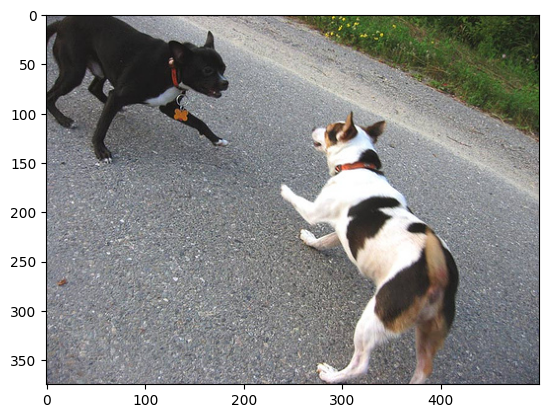

In [61]:
generate_caption("1001773457_577c3a7d70.jpg")


---------------------Actual---------------------
startseq startseq man in hat is displaying pictures next to skier in blue hat endseq endseq
startseq startseq man skis past another man displaying paintings in the snow endseq endseq
startseq startseq person wearing skis looking at framed pictures set up in the snow endseq endseq
startseq startseq skier looks at framed pictures in the snow next to trees endseq endseq
startseq startseq man on skis looking at artwork for sale in the snow endseq endseq
--------------------Predicted--------------------
startseq startseq skier in red and black uniform gets framed up up with skis on it endseq


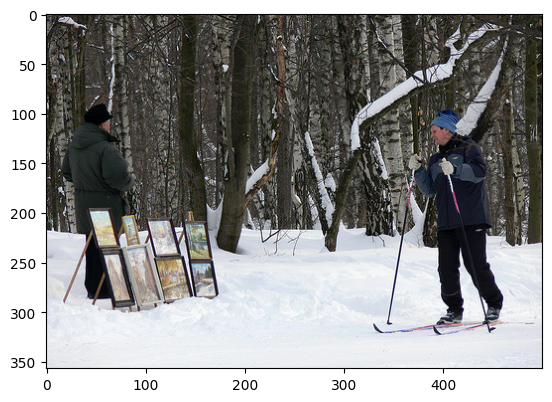

In [62]:
generate_caption("101669240_b2d3e7f17b.jpg")
